# 5. CNN을 이용한 분류 (CIFAR10)

합성곱 신경망(Convolutional Neural Network)를 이용한 이미지 분류

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 5.1 CIFAR10 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/data

/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/data


In [ ]:
# CIFAR10: 클래스 10개를 가진 이미지 데이터
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #평균과 표준편차 현재는 임의의 숫자를 넣어줌. 각 데이터셋마다 최적화된 평균과 표준편차를 구해서 정규화를 진행할 수 있다.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #train=True 설정하면 트레인 데이터를 불러오고 False로 설정하면 테스트 데이터를 불러온다.
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False) #테스트데이터는 섞어도 안섞어도 상관없다.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


## 5.2 CNN 모델 구축

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 합성곱 연산 (입력 채널수 3, 출력 채널수 6, 필터크기 5x5 , stride=1(defualt))
        self.pool1 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 합성곱 연산 (입력 채널수 6, 출력 채널수 16, 필터크기 5x5 , stride=1(defualt))
        self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개(400개)의 노드가 생성
        self.fc2 = nn.Linear(120, 10) # 120개 노드에서 클래스의 개수인 10개의 노드로 연산 #cifar 10 데이터는 10개의 클래스가 있다.

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)

        return x

net = Net().to(device) # 모델 선언


In [ ]:
print(net)
# 피쳐의 크기: 32 -> 28 ->14 -> 10 -> 5

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


## 5.3 모델 학습하기

In [ ]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9) #net.parameters는 net이라는 모델의 파라미터들을 업데이트하겠다는 의미

In [ ]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수

print("배치 개수 : ", n)

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # print("배치의 인덱스 : ", i,",실제 데이터 : ", data[0], ",라벨 : ", data[1])
        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = net(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

배치 개수 :  6250
[1] loss: 1.617
[2] loss: 1.331
[3] loss: 1.202
[4] loss: 1.119
[5] loss: 1.054
[6] loss: 0.998
[7] loss: 0.948
[8] loss: 0.908
[9] loss: 0.872
[10] loss: 0.839
Finished Training


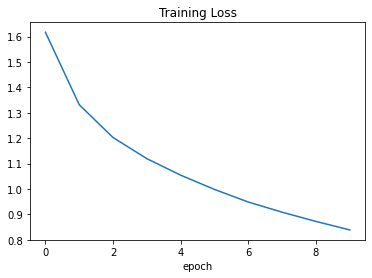

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.4 모델 저장하기

In [ ]:
PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/models/net_test.pth' # 모델 저장 경로 
torch.save(net.state_dict(), PATH) # 모델 저장

## 5.5 모델 불러오기

In [ ]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다. 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

## 5.6 모델 정확도(Accuracy) 구하기

In [ ]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    #net.eval() #현재는 모델에 드랍아웃이나, 패딩이 없어서 필요없지만 만약 사용된 경우에는 eval을 통해서 평가시에는 꼭 비활성화 시켜야한다.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0) # 개수 누적(총 개수)
       
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('전체 데이터 수 : ', total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

전체 데이터 수 :  10000
Accuracy of the network on the 10000 test images: 62 %


## 각 코드의 의미 뜯어보기

In [ ]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    #net.eval() #현재는 모델에 드랍아웃이나, 패딩이 없어서 필요없지만 만약 사용된 경우에는 eval을 통해서 평가시에는 꼭 비활성화 시켜야한다.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)

        print(outputs) #8개 배치 데이터 각가에서 10개의 확률을 뽑아냄 마지막 출력노드의 수가 10이었다. 즉 softmax(10)과 같음
        print()

        print('--------------------------------')
        
        print('non', torch.max(outputs.data)) #8개의 배치데이터에서 최고 값을 뽑아낸다.
        print()
        print('0',torch.max(outputs.data,0)) #각 컬럼별 최고 값을 뽑아낸다.
        print()
        print('1',torch.max(outputs.data,1)) #각 Low별 최고 값을 뽑아낸다.
        print()
        print('-1',torch.max(outputs.data,-1)) #각 컬럼별 최고 값을 뽑아낸다.
        print()
        print('-2',torch.max(outputs.data,-2)) #각 Low별 최고 값을 뽑아낸다.

        print('--------------------------------')
        print()

        _, predicted = torch.max(outputs.data, 1)
        
        print(_) #배치사이즈는 8이었음, 배치 8개 데이터 각각의 값을 뽑아옴/ 즉 확률 데이터 값을뽑아옴
        print()

        print('예측', predicted) #배치 8개의 데이터 각각의 예측라벨 8개를 뽑아냄 
        print('실제값', labels)
        print()

        print('전체 원소개수: ', labels.size(0)) #전체 원소의 개수 반환
        print('확인용 : ', labels.size()) #-1 혹은 0 아무 숫자나 넣어줘야 int형태로 출력할 수 있다. 만약 숫자를 지정하지 않는다면 리스트 형태로 출력
        print()

        total += labels.size(0) # 개수 누적(총 개수)
       
        print()
        print(predicted == labels) 
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        print('정답:' ,correct)
        print()

        break
print('총 개수 : ', total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

tensor([[-2.6183, -0.9079,  1.5770,  5.5308, -0.7189,  3.0497,  1.2285, -1.2757,
         -1.2808, -0.4200],
        [ 5.1755,  5.0603, -2.8037, -0.3574, -5.1188, -3.7917, -5.8326, -2.9025,
          8.8155,  2.2266],
        [ 0.9933,  1.9442,  0.2858, -0.1570, -3.5217, -2.1280, -1.2215, -1.3707,
          2.7718,  3.0011],
        [ 3.7643, -2.2253,  0.9047,  0.5352,  0.9094, -0.4245, -2.7193, -1.8692,
          1.7218,  0.3036],
        [-3.4518, -3.5967,  3.2409,  3.7253,  3.8494,  3.0619,  5.2486, -2.5026,
         -3.5429, -4.3972],
        [-2.8912, -3.4158,  0.5962,  1.1934,  2.9718,  1.8667,  4.2821,  0.6519,
         -4.2598, -2.1205],
        [-2.3148,  1.9670, -1.5458,  0.9429,  0.5806,  0.8386, -1.4035, -1.6949,
         -3.4113,  3.1579],
        [-2.7335, -3.8227,  2.5048,  2.7268,  5.1613,  1.7418,  4.2183, -0.3566,
         -5.0394, -4.1712]], device='cuda:0')

--------------------------------
non tensor(8.8155, device='cuda:0')

0 torch.return_types.max(
values=tensor

## Commit

In [ ]:
cd/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic

/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic


In [ ]:
!git config --global user.email "injaeda7@gmail.com"
!git config --global user.name "SEOINJAE"

In [ ]:
!git pull

Already up to date.


In [ ]:
!git add .

In [ ]:
!git commit -m "chapter 4 done"

[master 3fe5d1f] chapter 4 done
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!git push

Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 18.62 KiB | 1.43 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 2 local objects.
To https://github.com/SEOINJAE/Deeplearning.git
   073f9ec..3fe5d1f  master -> master
